In [1]:
import pandas as pd
import numpy as np
import gc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Plotting
import matplotlib.pyplot as plt

import seaborn as sns 

## Data Preprocessing

In [2]:
voter_df = pd.read_csv('../data/voter_turnout_merged_all_states.csv')
print("shape: ",voter_df.shape)
voter_df.head()

shape:  (1492, 69)


,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,total_voters_college,total_voters_no_college,voted_voters_college,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122.0,23041.0,...,80668.0,27989.0,71356.0,22543.0,88.456389,80.542356,47.829424,331652,172221.0,CA
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122.0,14972.0,...,80668.0,27989.0,59248.0,17372.0,73.446720,62.067241,48.224196,331652,130249.0,CA
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122.0,16057.0,...,80668.0,27989.0,60766.0,18951.0,75.328507,67.708743,46.819512,331652,135633.0,CA
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122.0,8145.0,...,80668.0,27989.0,38216.0,10811.0,47.374424,38.625889,51.034918,331652,75153.0,CA
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780.0,9229.0,...,19051.0,10653.0,16014.0,8674.0,84.058580,81.423073,49.752550,70359,41879.0,CA


In [3]:
print([col for col in voter_df.columns if 'total_voters'  in col])

['total_voters_asian', 'total_voters_black', 'total_voters_hispanic', 'total_voters_others', 'total_voters_white', 'total_voters_$1000-14999', 'total_voters_$100000-124999', 'total_voters_$125000-149999', 'total_voters_$15000-24999', 'total_voters_$150000-174999', 'total_voters_$175000-199999', 'total_voters_$200000-249999', 'total_voters_$25000-34999', 'total_voters_$250000+', 'total_voters_$35000-49999', 'total_voters_$50000-74999', 'total_voters_$75000-99999', 'total_voters_college', 'total_voters_no_college']


In [4]:
voted_voters_cols = [col for col in voter_df.columns if 'voted_voters' in col ]
print(voted_voters_cols)

['voted_voters_asian', 'voted_voters_black', 'voted_voters_hispanic', 'voted_voters_others', 'voted_voters_white', 'voted_voters_$1000-14999', 'voted_voters_$100000-124999', 'voted_voters_$125000-149999', 'voted_voters_$15000-24999', 'voted_voters_$150000-174999', 'voted_voters_$175000-199999', 'voted_voters_$200000-249999', 'voted_voters_$25000-34999', 'voted_voters_$250000+', 'voted_voters_$35000-49999', 'voted_voters_$50000-74999', 'voted_voters_$75000-99999', 'voted_voters_college', 'voted_voters_no_college', 'voted_voters']


In [5]:
#replace all NAN for voted_voters and total_voters counts  with 0

voters_col = [col for col in voter_df.columns if 'voted_voters' in col or 'total_voters'  in col]
voter_df[voters_col] = voter_df[voters_col].fillna(0) 

In [6]:
#double check to make sure the sum adds up
print("num mismatch voted_voters and by race:", sum(voter_df['voted_voters'] != voter_df['voted_voters_asian'] + 
          voter_df['voted_voters_black']+voter_df['voted_voters_hispanic'] + 
          voter_df['voted_voters_others'] + voter_df['voted_voters_white']))

num mismatch voted_voters and by race: 0


In [7]:
# `voter_population` is calculated from census data for people over age 20
# calculate new `total_voters columns` that should be used instead.
voter_df['total_voters'] = voter_df['total_voters_asian'] + voter_df['total_voters_black']+voter_df['total_voters_hispanic'] + voter_df['total_voters_others'] + voter_df['total_voters_white']
print("num mismatch total_voters and voter_population:", sum(voter_df['total_voters'] !=  voter_df['voter_population']))
print("shape of voter_df:", voter_df.shape)


num mismatch total_voters and voter_population: 1492
shape of voter_df: (1492, 70)


In [8]:
voter_df.Residence_Addresses_City.nunique()

213

In [9]:
#adding outcome features for income

voter_df['perc_turnout_under_50k'] = (voter_df['voted_voters_$1000-14999'] + 
                                voter_df['voted_voters_$15000-24999'] + 
                                voter_df['voted_voters_$25000-34999'] + 
                                voter_df['voted_voters_$35000-49999']) / \
                               (voter_df['total_voters_$1000-14999'] + 
                                voter_df['total_voters_$15000-24999'] + 
                                voter_df['total_voters_$25000-34999'] + 
                                voter_df['total_voters_$35000-49999'])
            
voter_df['perc_turnout_over_100k'] = (voter_df['voted_voters_$100000-124999'] + 
                                voter_df['voted_voters_$125000-149999'] + 
                                voter_df['voted_voters_$150000-174999'] +  
                                voter_df['voted_voters_$175000-199999'] + 
                                voter_df['voted_voters_$200000-249999'] + 
                                voter_df['voted_voters_$250000+']) / \
                               (voter_df['total_voters_$100000-124999'] + 
                                voter_df['total_voters_$125000-149999'] + 
                                voter_df['total_voters_$150000-174999'] +  
                                voter_df['total_voters_$175000-199999'] + 
                                voter_df['total_voters_$200000-249999'] + 
                                voter_df['total_voters_$250000+'])

voter_df.head()

,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state,total_voters,perc_turnout_under_50k,perc_turnout_over_100k
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122.0,23041.0,...,22543.0,88.456389,80.542356,47.829424,331652,172221.0,CA,221000.0,0.693252,0.852955
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122.0,14972.0,...,17372.0,73.446720,62.067241,48.224196,331652,130249.0,CA,221000.0,0.478709,0.686407
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122.0,16057.0,...,18951.0,75.328507,67.708743,46.819512,331652,135633.0,CA,221000.0,0.528991,0.692809
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122.0,8145.0,...,10811.0,47.374424,38.625889,51.034918,331652,75153.0,CA,221000.0,0.273848,0.408208
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780.0,9229.0,...,8674.0,84.058580,81.423073,49.752550,70359,41879.0,CA,54538.0,0.770270,0.793565


In [10]:
voter_df[voter_df['perc_turnout_under_50k'].isnull()]

,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state,total_voters,perc_turnout_under_50k,perc_turnout_over_100k
420,Timonium,2020_11_03,2020,General,1.0,0.0,0.0,0.0,5.0,1.0,...,0.0,100.0,NaN,62.555699,8343,6.0,MD,6.0,NaN,1.0
421,Timonium,2018_11_06,2018,General,1.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,NaN,71.290535,8343,3.0,MD,6.0,NaN,0.5
422,Timonium,2016_11_08,2016,General,1.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,NaN,69.297339,8343,3.0,MD,6.0,NaN,0.5
423,Timonium,2014_11_04,2014,General,1.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,NaN,67.284977,8343,3.0,MD,6.0,NaN,0.5
448,North Bethesda,2020_11_03,2020,General,0.0,0.0,1.0,1.0,4.0,0.0,...,0.0,50.0,NaN,50.697824,39494,3.0,MD,6.0,NaN,0.6
449,North Bethesda,2018_11_06,2018,General,0.0,0.0,1.0,1.0,4.0,0.0,...,0.0,100.0,NaN,51.076568,39494,3.0,MD,6.0,NaN,0.4
450,North Bethesda,2016_11_08,2016,General,0.0,0.0,1.0,1.0,4.0,0.0,...,0.0,100.0,NaN,49.083372,39494,3.0,MD,6.0,NaN,0.4
451,North Bethesda,2014_11_04,2014,General,0.0,0.0,1.0,1.0,4.0,0.0,...,0.0,50.0,NaN,70.884412,39494,1.0,MD,6.0,NaN,0.2


In [11]:
#drop rows with missing values (these rows look like they have very low turnout anyway)
voter_df.dropna(inplace=True)
#checking rows with missing values
voter_df.columns[voter_df.isna().any()].tolist()

[]

In [12]:
#define RCV and non-rcv cities
rcv_cities = ['Albany', 'Berkeley', 'Eureka', 'Oakland', 'Palm Desert', 'San Francisco', 'San Leandro',
             'Las Cruces', 'Santa Fe', 'Boulder', 'Burlington', 'Portland', 'Takoma Park', 'Bluffdale',
             'Payson', 'Cottonwood Heights', 'Salt Lake City', 'Sandy', 'Midvale', 'Draper', 'Lehi',
             'Springville', 'South Salt Lake', 'Magna', 'Heber', 'Millcreek', 'Riverton', 'St. Louis Park',
             'Bloomington', 'Minneapolis', 'Minnetonka']
non_rcv_cities = list(set(voter_df['Residence_Addresses_City']) - set(rcv_cities))

#function to generate rcv labels
def label_rcv(row):
    if row['Residence_Addresses_City'] in rcv_cities:
        return 1
    else:
        return 0
    
#add rcv label
voter_df['rcv'] = voter_df.apply(lambda row: label_rcv(row), axis=1)

#add turnout column
voter_df['turnout'] = voter_df['voted_voters'] / voter_df['total_voters']


In [13]:
#specify columns to use. Don't want to use data that already has turnout information
# 'FECDonors_TotalDonationsAmount' can be removed since it can be computed using mean_donation and FECDonors_NumberOfDonations
use_cols = ['Residence_Addresses_City', 'state', 'elec_type', 
             'rcv', 'turnout', 'perc_turnout_white', 'mean_age', 'perc_turnout_under_50k',
           'perc_turnout_over_100k']

#filter to usable columns (i.e. columns that do not show turnout)
voter_df = voter_df[use_cols]
voter_df.head()

,Residence_Addresses_City,state,elec_type,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
0,Oakland,CA,General,1,0.779281,84.200332,47.829424,0.693252,0.852955
1,Oakland,CA,General,1,0.589362,69.622964,48.224196,0.478709,0.686407
2,Oakland,CA,General,1,0.613724,69.738457,46.819512,0.528991,0.692809
3,Oakland,CA,General,1,0.340059,42.601237,51.034918,0.273848,0.408208
4,San Leandro,CA,General,1,0.767887,82.328459,49.752550,0.770270,0.793565


In [14]:
#checking rows with missing values
voter_df.columns[voter_df.isna().any()].tolist()

[]

In [15]:
print("Total number of rcv cities:", voter_df.groupby(['Residence_Addresses_City', 'state']).ngroups)
print("Number of rcv cities:", voter_df[voter_df['rcv']== 1].groupby(['Residence_Addresses_City', 'state']).ngroups)
print("Number of non rcv cities:", voter_df[voter_df['rcv']== 0].groupby(['Residence_Addresses_City', 'state']).ngroups)

Total number of rcv cities: 204
Number of rcv cities: 29
Number of non rcv cities: 175


In [16]:
#group by city and election type
voter_df = voter_df.groupby(['Residence_Addresses_City', 'elec_type','state'], as_index=False).mean()

#Need both city and state to merge with census data
# df.drop(columns=['Residence_Addresses_City'], inplace=True)

voter_df.head()


,Residence_Addresses_City,elec_type,state,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
0,Adelphi,General,MD,0.0,0.455109,51.538988,54.184656,0.474739,0.501815
1,Alamogordo,General,NM,0.0,0.491373,51.930341,57.574886,0.489294,0.554673
2,Alamogordo,Local_or_Municipal,NM,0.0,0.114373,12.804169,61.541445,0.110822,0.138876
3,Alamosa,Consolidated_General,CO,0.0,0.348872,39.124792,56.419342,0.306489,0.432444
4,Alamosa,General,CO,0.0,0.596245,63.335756,51.515875,0.539032,0.687079


In [17]:
#examine data
print(voter_df.shape)
voter_df.describe()

(355, 9)


,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,0.146479,0.429763,45.615914,53.601228,0.454661,0.460641
std,0.354085,0.201575,20.796904,3.987326,0.209457,0.206921
min,0.000000,0.065370,7.666349,40.656594,0.047074,0.065155
25%,0.000000,0.234395,24.977112,50.799581,0.272259,0.251885
50%,0.000000,0.483349,51.930341,53.327358,0.483298,0.546967
75%,0.000000,0.602780,63.844511,56.634865,0.630545,0.640483
max,1.000000,0.756453,78.641634,63.042398,0.812635,0.774744


In [18]:
print(voter_df.columns[voter_df.isna().any()].tolist())

[]


# Census Data

In [19]:
cities = pd.read_csv('../data/cities.csv', usecols=['state_id', 'RCV', 'city_ascii',  
                                                   'population_proper',
                                                    'race_white', 
                                                    'education_college_or_above',
                                                    'age_median', 
                                                    'income_household_median'])
print(cities.state_id.unique())

CA_cities = pd.read_csv('../data/ca-cities.csv', usecols=['state_id', 'RCV', 'city_ascii', 
                                                          'race_white', 
                                                          'population_proper',
                                                          'education_college_or_above',
                                                          'age_median', 
                                                          'income_household_median'])

cities = pd.concat([cities, CA_cities])
cities = cities.rename(columns = {'RCV': 'rcv', 'city_ascii': 'Residence_Addresses_City',
                                 'state_id': 'state'})
cities['rcv'] = cities['rcv'].fillna(0)

cities.head()



['NM' 'CO' 'VT' 'ME' 'MD' 'UT' 'MN']


,rcv,Residence_Addresses_City,state,population_proper,age_median,income_household_median,education_college_or_above,race_white
0,0.0,Los Alamos,NM,12035,41.7,101399,66.5,84.4
1,0.0,Albuquerque,NM,558545,36.2,49878,34.3,73.6
2,0.0,Rio Rancho,NM,96159,38.1,63180,30.2,79.9
3,0.0,Farmington,NM,45450,32.9,55179,20.2,61.1
4,0.0,North Valley,NM,11999,48.1,50236,28.0,74.9


In [20]:
cities.describe()

,rcv,population_proper,age_median,income_household_median,education_college_or_above,race_white
count,913.000000,9.130000e+02,913.000000,913.000000,913.000000,913.000000
mean,0.033954,5.636355e+04,36.791566,73569.914567,33.390361,68.947426
std,0.181210,1.596584e+05,6.038693,29671.599317,18.023748,21.930579
min,0.000000,3.564000e+03,19.200000,23541.000000,1.800000,3.500000
25%,0.000000,1.548200e+04,33.000000,52136.000000,19.200000,56.100000
50%,0.000000,2.640500e+04,36.600000,67614.000000,31.300000,74.900000
75%,0.000000,5.876600e+04,40.500000,89446.000000,45.000000,86.700000
max,1.000000,3.999759e+06,75.300000,238750.000000,95.300000,98.700000


In [21]:
print(cities.columns.values)
print(cities.shape)


['rcv' 'Residence_Addresses_City' 'state' 'population_proper' 'age_median'
 'income_household_median' 'education_college_or_above' 'race_white']
(913, 8)


In [22]:
def get_cols_model(df, cities_df, target):

    selected_df = df[['rcv', 
                      'state', 
                      'Residence_Addresses_City', 
                      'elec_type',
                      target]]
    selected_df = selected_df.merge(cities, 
                     on = ['Residence_Addresses_City', 'rcv', 'state'], how = 'left')
    
    #one-hot encode categorical cols
    cat_cols = ['elec_type', 'state']

    selected_df = pd.get_dummies(data=selected_df, columns=cat_cols)

    return  selected_df

df_turnout = get_cols_model(voter_df, cities, 'turnout')           
print(df_turnout.shape)
df_turnout.head()

(355, 19)


,rcv,Residence_Addresses_City,turnout,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.455109,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.491373,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.114373,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.348872,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.596245,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


In [23]:
df_white_turnout = get_cols_model(voter_df, cities, 'perc_turnout_white') 
df_mean_age = get_cols_model(voter_df, cities, 'mean_age')                      
df_turnout_under_50k = get_cols_model(voter_df, cities, 'perc_turnout_under_50k')                      
df_turnout_over_100k = get_cols_model(voter_df, cities, 'perc_turnout_over_100k')      


# Model Implementation

## 1. Predict turnout

### 1.1 Random Forest

In [24]:
def get_metrics(target, prediction, is_train):
    
    # Mean absolute error (MAE)
    mae = mean_absolute_error(target.values.ravel(), prediction)

    # Mean squared error (MSE)
    mse = mean_squared_error(target.values.ravel(), prediction)

    # R-squared scores
    r2 = r2_score(target.values.ravel(), prediction)
    
    df = pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])
    
    if is_train == True:
        print("Train")
        df.columns = ['metric', 'rf_train']
    elif is_train ==False:
        print("\nTest")
        df.columns = ['metric', 'rf_test']
        
    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('R-squared scores:', round(r2, 3))
    
    return df

#function to generate and print ordered list of feature importance scores
def ordered_feature_importance(features, feature_importances, n=10):
    features = list(features)
    feature_importance = list(feature_importances)
    
    zipped = zip(features, feature_importance)
    sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
    
    unzipped = list(zip(*sorted_zipped))
    sorted_features = list(unzipped[0])
    sorted_feature_importance = list(unzipped[1])

    for i in range(n):
        print('Feature {} ({}) importance: {}'.format(i, sorted_features[i], sorted_feature_importance[i]))
    
    return sorted_features, sorted_feature_importance

def plot_feature_importance(importance,names,fig_title, file_name):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(fig_title)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.tight_layout()
    plt.savefig(f'../data/plots/{file_name}.jpg')

rng = np.random.RandomState(0)

def train(df, target):
    print(target)
    # split the data in 80:20 for train:test dataset
    train_size=0.8
    rng = np.random.RandomState(0)

    X = df.drop(columns=[target,'Residence_Addresses_City'])
    y = df[target]

    # In the first step we will split the data in training and remaining dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=0.8, 
                                                        random_state=rng)
    
    del X, y
    print("train:", X_train.shape, y_train.shape)
    print("test:", X_test.shape, y_test.shape)
    
    #implement random forest
    tuned_parameters = {'n_estimators': [10, 50, 100], 
                        'max_depth': [None, 2, 3], 
                        'max_features': [4, 8, 16, 20, 24]}

    model = GridSearchCV(RandomForestRegressor(bootstrap = True, 
                                               random_state = rng), 
                                 tuned_parameters, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 verbose=1)

    model.fit(X_train, y_train)
    model.score(X_train, y_train)
    best_params = model.best_params_ 
    print("\nBest params after cv:", best_params,'\n')
    
    del model

    best_model = RandomForestRegressor(bootstrap = True, 
                                       random_state = rng, 
                                       max_depth= best_params['max_depth'], 
                                       max_features= best_params['max_features'], 
                                       n_estimators = best_params['n_estimators'])

    best_model.fit(X_train, y_train)

    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    
    del X_test
    rf_train_metric = get_metrics(y_train, 
                                   train_pred, 
                                   is_train = True)
    rf_test_metric = get_metrics(y_test, 
                                  test_pred, 
                                  is_train = False)
    combine_metric = pd.merge(rf_train_metric, 
                              rf_test_metric, on = "metric")
    print(combine_metric)
    
    del y_train, y_test, train_pred, test_pred
    #del rf_overall_train. rf_overall_test
    
    print('\n')
    sorted_features, sorted_feature_importance = ordered_feature_importance(X_train.columns, 
                                                                            best_model.feature_importances_, 
                                                                            n=len(X_train.columns))
    plot_feature_importance(best_model.feature_importances_, 
                            X_train.columns,
                            fig_title = f'(Supervised) Random Forest feature importance for {target}', 
                            file_name = f'RF_feature_imp_supervised_{target}')                                                     
    del best_model
    return best_params, combine_metric

turnout
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best params after cv: {'max_depth': None, 'max_features': 8, 'n_estimators': 50} 

Train
Mean Absolute Error: 0.014
Mean Squared Error: 0.0
R-squared scores: 0.991

Test
Mean Absolute Error: 0.044
Mean Squared Error: 0.003
R-squared scores: 0.926
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.014282  0.044013
1   Mean_Squared_Error  0.000345  0.003174
2      R_squared_score  0.991334  0.926169


Feature 0 (elec_type_General) importance: 0.4909407245836028
Feature 1 (elec_type_Consolidated_General) importance: 0.1698425191498233
Feature 2 (elec_type_Local_or_Municipal) importance: 0.12316246474875384
Feature 3 (education_college_or_above) importance: 0.05108434103350776
Feature 4 (state_CO) importance: 0.03453217753987014
Feature 5 (race_white) importance: 0.032573571009247994
Feature 6 (income_household_median) importance: 0.022830145589524013
Featur

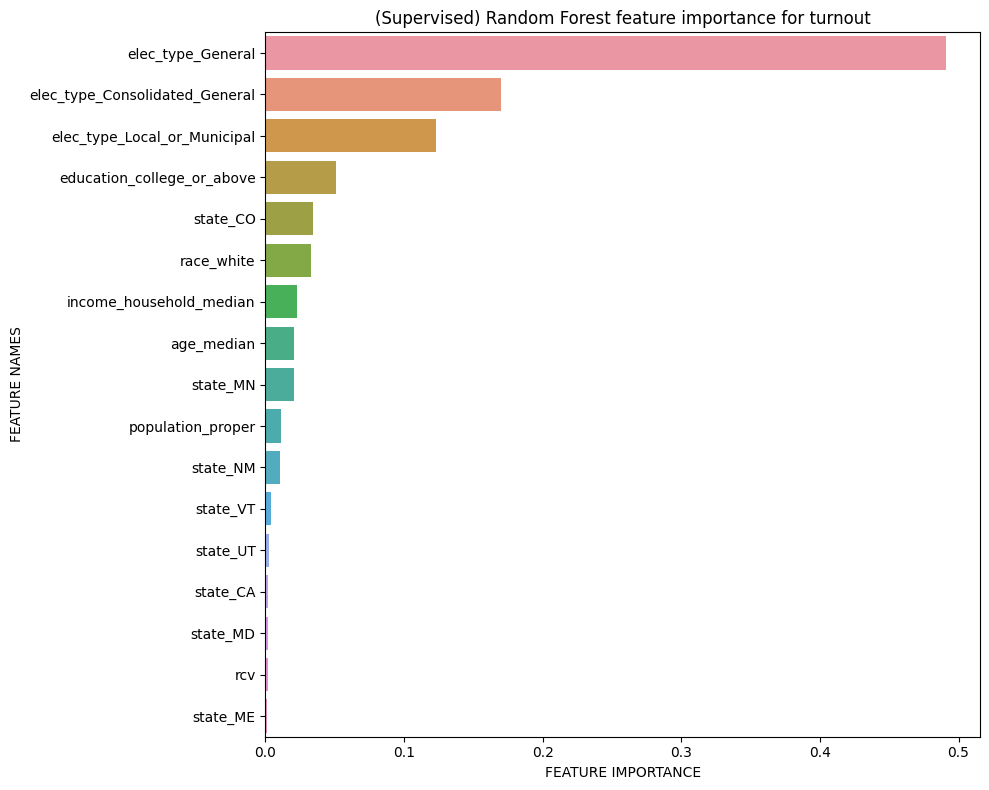

In [25]:
best_params_turnout, rf_metric_turnout = train(df_turnout, 'turnout')

In [26]:
print(best_params_turnout)
print(rf_metric_turnout)

{'max_depth': None, 'max_features': 8, 'n_estimators': 50}
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.014282  0.044013
1   Mean_Squared_Error  0.000345  0.003174
2      R_squared_score  0.991334  0.926169


### feature importance for RCV and Non RCV 


#### RCV

Target:  turnout

 RCV Cross Validation
df shape: (52, 16) (52,)
Cross validation Mean Absolute Error score: 0.052
Cross validation Mean Squared Error score: 0.005
Cross validation R-sqaured score: 0.869

                 metric  rf_rcv_cv_turnout
0  Mean_Absolute_Error              0.052
1   Mean_Squared_Error              0.005
2      R_squared_score              0.869 

Feature 0 (elec_type_General) importance: 0.5622484175731742
Feature 1 (elec_type_Consolidated_General) importance: 0.229480455491675
Feature 2 (elec_type_Local_or_Municipal) importance: 0.03920850919619944
Feature 3 (income_household_median) importance: 0.038735877805469415
Feature 4 (education_college_or_above) importance: 0.03610041291717802
Feature 5 (age_median) importance: 0.024292579885581037
Feature 6 (race_white) importance: 0.020570299435276492
Feature 7 (population_proper) importance: 0.015847187717274794
Feature 8 (state_MN) importance: 0.01304875660103041
Feature 9 (state_CO) importance: 0.00628493563308

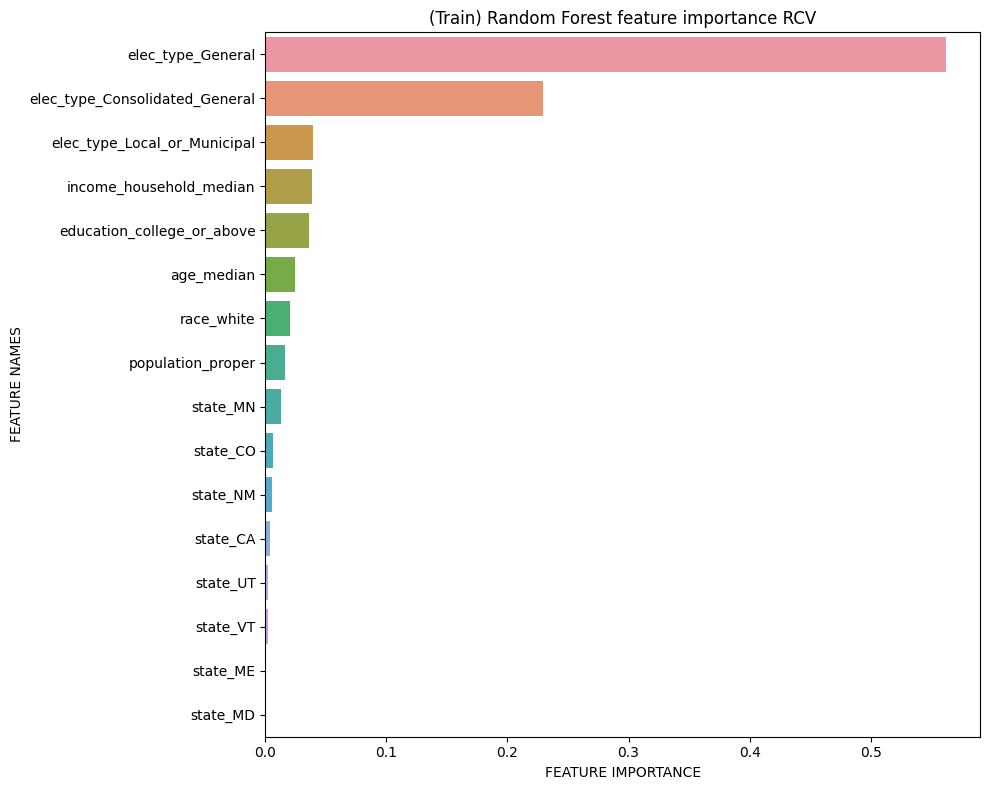

In [27]:
#implement random forest rcv
def get_metrics_CV(model, data, target):
    mae = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)), 3)
    mse = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_squared_error', cv=10, n_jobs=-1)), 3)
    r2 = round(np.mean(cross_val_score(model, data, target, 
                                  scoring='r2', cv=10, n_jobs=-1)), 3)
    
    print("Cross validation Mean Absolute Error score:", mae)
    print("Cross validation Mean Squared Error score:", mse)
    print("Cross validation R-sqaured score:", r2)
    return pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])

def rf_rcv_nonrcv(df, is_rcv, target, best_params):
    print("Target: ", target)
    
    if is_rcv == True:
        rcv_df = df[df['rcv'] == 1]
        print("\n RCV Cross Validation")
        plot_title = '(Train) Random Forest feature importance RCV'
        fig_save_name = 'RF_feature_imp_RCV'
    elif is_rcv == False:
        rcv_df = df[df['rcv'] == 0]
        print("\n Non RCV Cross Validation")
        plot_title = '(Train) Random Forest feature importance Non RCV'
        fig_save_name = 'RF_feature_imp_Non_RCV'
        
    rcv_y = rcv_df[target]
    rcv_X = rcv_df.drop(columns=[target, 'rcv','Residence_Addresses_City'])
    print("df shape:", rcv_X.shape, rcv_y.shape)

    rcv_rf = RandomForestRegressor(bootstrap = True, 
                                   oob_score = True, 
                                   random_state = 0, 
                                   max_depth= best_params['max_depth'], 
                                   max_features= best_params['max_features'], 
                                   n_estimators = best_params['n_estimators'])
    rcv_rf.fit(rcv_X, rcv_y)
    rcv_pred = rcv_rf.predict(rcv_X)
    rf_rcv_cv = get_metrics_CV(rcv_rf, rcv_X, rcv_y)
    
    
    if is_rcv == True:
        rf_rcv_cv.columns = ['metric', f'rf_rcv_cv_{target}']
    elif is_rcv == False:
        rf_rcv_cv.columns = ['metric', f'rf_nonrcv_cv_{target}']
        
    print("\n", rf_rcv_cv,"\n")
    
    #generate and print ordered list of feature importance scores
    rf_sorted_features, rf_sorted_feature_importance = ordered_feature_importance(rcv_X.columns, 
                                                                                  rcv_rf.feature_importances_, 
                                                                                  n=len(rcv_X.columns))
                                          
    plot_feature_importance(rcv_rf.feature_importances_, 
                            rcv_X.columns, 
                        fig_title = plot_title, 
                        file_name = fig_save_name)
                                                       
    return rf_rcv_cv, rf_sorted_features, rf_sorted_feature_importance

rf_rcv_turnout, rcv_features_turnout, rcv_feature_importance_turnout = rf_rcv_nonrcv(df_turnout, 
                                                                                     is_rcv = True, 
                                                                                     target = 'turnout', 
                                                                                     best_params =  best_params_turnout)

#### Non-RCV

Target:  turnout

 Non RCV Cross Validation
df shape: (303, 16) (303,)
Cross validation Mean Absolute Error score: 0.039
Cross validation Mean Squared Error score: 0.002
Cross validation R-sqaured score: 0.938

                 metric  rf_nonrcv_cv_turnout
0  Mean_Absolute_Error                 0.039
1   Mean_Squared_Error                 0.002
2      R_squared_score                 0.938 

Feature 0 (elec_type_General) importance: 0.5480350133165248
Feature 1 (elec_type_Consolidated_General) importance: 0.15315475715693688
Feature 2 (elec_type_Local_or_Municipal) importance: 0.08701971204165204
Feature 3 (education_college_or_above) importance: 0.05052807781100811
Feature 4 (state_CO) importance: 0.036781049408692965
Feature 5 (age_median) importance: 0.03109324151940541
Feature 6 (race_white) importance: 0.030715411385349375
Feature 7 (state_MN) importance: 0.014986247151471763
Feature 8 (income_household_median) importance: 0.014868808052417937
Feature 9 (state_NM) importance: 0.013

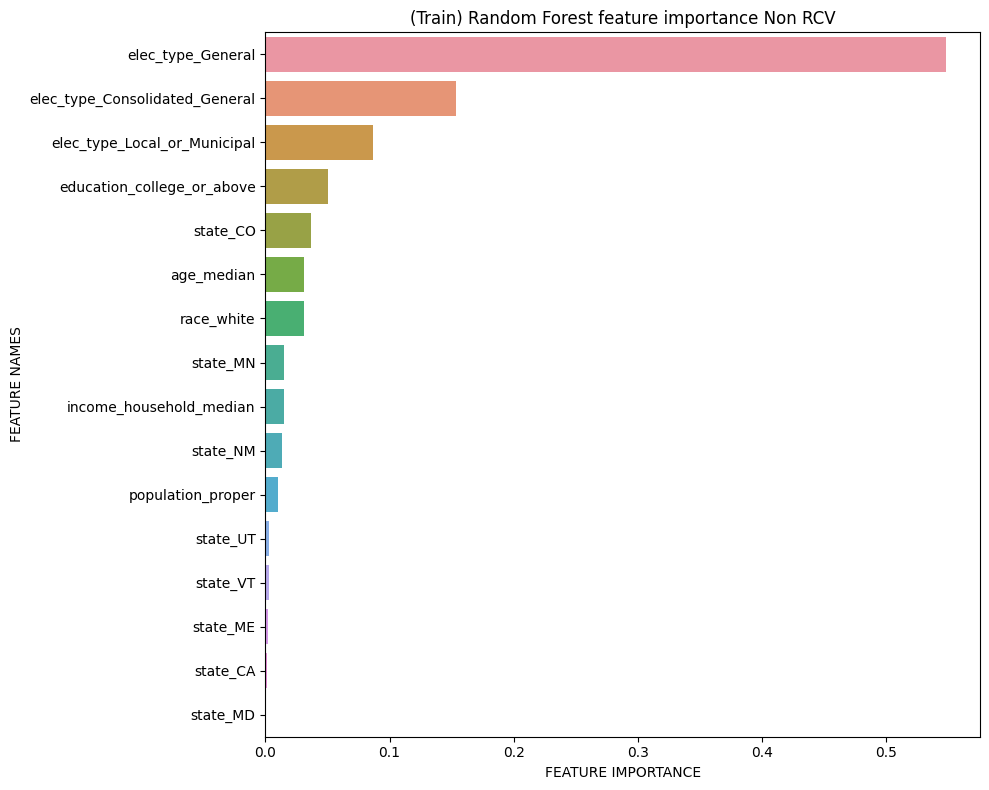

In [28]:
rf_nonrcv_turnout, non_rcv_features_turnout, non_rcv_feature_importance_turnout = rf_rcv_nonrcv(df_turnout, 
                                  is_rcv = False, 
                                  target = 'turnout', 
                                  best_params = best_params_turnout)

#### RCV vs. Non-RCV

In [29]:
nonrcv_df_turnout = pd.DataFrame({'feature': non_rcv_features_turnout, 
                              'importance_nonrcv': non_rcv_feature_importance_turnout})
rcv_df_turnout = pd.DataFrame({'feature': rcv_features_turnout, 
                       'importance_rcv': rcv_feature_importance_turnout})
rcv_df_turnout.merge(nonrcv_df_turnout, right_index = True, left_index = True)

,feature_x,importance_rcv,feature_y,importance_nonrcv
0,elec_type_General,0.562248,elec_type_General,0.548035
1,elec_type_Consolidated_General,0.229480,elec_type_Consolidated_General,0.153155
2,elec_type_Local_or_Municipal,0.039209,elec_type_Local_or_Municipal,0.087020
3,income_household_median,0.038736,education_college_or_above,0.050528
4,education_college_or_above,0.036100,state_CO,0.036781
5,age_median,0.024293,age_median,0.031093
6,race_white,0.020570,race_white,0.030715
7,population_proper,0.015847,state_MN,0.014986
8,state_MN,0.013049,income_household_median,0.014869
9,state_CO,0.006285,state_NM,0.013368


                          feature  importance_nonrcv  importance_rcv
0               elec_type_General           0.548035        0.562248
1  elec_type_Consolidated_General           0.153155        0.229480
2    elec_type_Local_or_Municipal           0.087020        0.039209
3      education_college_or_above           0.050528        0.036100
4                        state_CO           0.036781        0.006285
                          feature           variable     value
0               elec_type_General  importance_nonrcv  0.548035
1  elec_type_Consolidated_General  importance_nonrcv  0.153155
2    elec_type_Local_or_Municipal  importance_nonrcv  0.087020
3      education_college_or_above  importance_nonrcv  0.050528
4                        state_CO  importance_nonrcv  0.036781


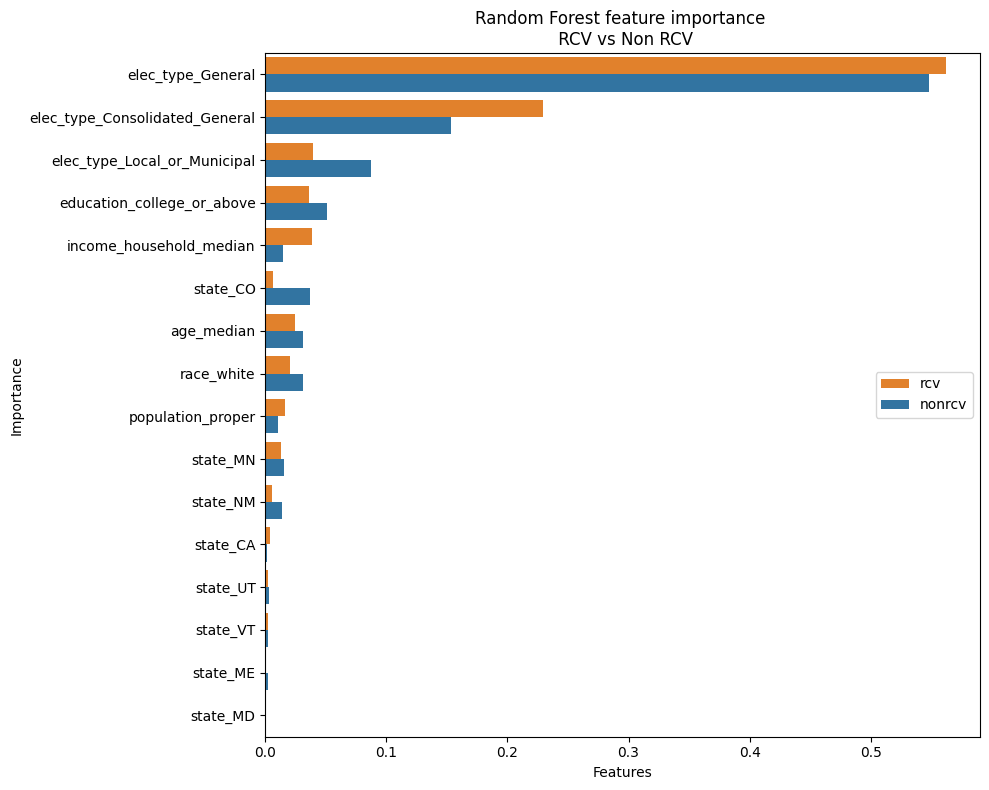

In [30]:
#Match features
def plot_importance_rcv_nonrcv(nonrcv_df, rcv_df):
    
    rcv_v_nonrcv_df = nonrcv_df.merge(rcv_df, on = "feature")
    print(rcv_v_nonrcv_df.head())
    
    rcv_v_nonrcv_df = pd.melt(rcv_v_nonrcv_df, id_vars=['feature'], value_vars=['importance_nonrcv','importance_rcv'])
    print(rcv_v_nonrcv_df.head())
    
    #Create arrays from feature importance and feature names
    variable = np.array(rcv_v_nonrcv_df['variable'])
    value = np.array(rcv_v_nonrcv_df['value'])
    feature_names = np.array(rcv_v_nonrcv_df['feature'])

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'variable':variable,'value':value}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df.replace({'importance_nonrcv': 'nonrcv', 'importance_rcv': 'rcv'})

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['value'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    palette ={"nonrcv": "C0", "rcv": "C1"}

    sns.barplot(x=fi_df['value'], y=fi_df['feature_names'], hue = fi_df['variable'], palette=palette)

    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Random Forest feature importance \n RCV vs Non RCV')
    plt.legend(loc='center right')
    plt.tight_layout()
    plt.savefig(f'../data/plots/RF_feature_imp_RCV_vs_Non_RCV.jpg')

    
plot_importance_rcv_nonrcv(nonrcv_df_turnout, rcv_df_turnout)
    

In [31]:
del rcv_df_turnout, nonrcv_df_turnout
gc.collect()

27138

### 1.1 Linear Regression

In [32]:
# importing modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [33]:
df_turnout.head()

,rcv,Residence_Addresses_City,turnout,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.455109,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.491373,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.114373,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.348872,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.596245,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


In [34]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats


def train_lrg_sm(df, target):
    X = df.drop(columns=[target,'Residence_Addresses_City'])
    y = df[target]
    # In the first step we will split the data in training and remaining dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=0.8, 
                                                        random_state=rng)
    num_cols = [col for col in X.columns if col in ['population_proper',
                                                 'age_median',
                                                 'income_household_median',
                                                 'education_college_or_above', 
                                                 'race_white']]
    
    ct = ColumnTransformer([
            ('somename', StandardScaler(), num_cols)
        ], remainder='passthrough')

    ct.fit(X_train)
    
    scaled_X_train = pd.DataFrame(ct.transform(X_train), 
                                  columns = X_train.columns)
    scaled_X_test = pd.DataFrame(ct.transform(X_test), 
                                 columns = X_test.columns)
    print(scaled_X_train.shape)
    print(y_train.shape)
    train_X2 = sm.add_constant(scaled_X_train)
    test_X2 = sm.add_constant(scaled_X_test)
    est = sm.OLS(list(y_train), train_X2)
    est2 = est.fit()
    
    print(est2.summary())
    
    train_pred = est2.predict(train_X2)
    test_pred = est2.predict(test_X2)

    del est, est2, ct 
    
    print("Train")
    linreg_train_metric = get_metrics(y_train, train_pred, is_train =True)
    linreg_train_metric.columns = ['metric', 'linreg_train']

    print("Test")
    linreg_test_metric = get_metrics(y_test, test_pred, is_train =False)
    linreg_test_metric.columns = ['metric', 'linreg_test']
    
    combine_metric = pd.merge(linreg_train_metric, 
                              linreg_test_metric, on = "metric")
    
    return combine_metric

In [35]:
linreg_metric_turnout = train_lrg_sm(df_turnout, 'turnout') 
linreg_metric_turnout

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     194.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.12e-134
Time:                        15:05:37   Log-Likelihood:                 406.13
No. Observations:                 284   AIC:                            -780.3
Df Residuals:                     268   BIC:                            -721.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.046055,0.043991
1,Mean_Squared_Error,0.003353,0.003380
2,R_squared_score,0.915874,0.921385


### Compare Random Forest and Linear Regression

In [36]:
pd.merge(rf_metric_turnout, linreg_metric_turnout, on = "metric")


,metric,rf_train,rf_test,linreg_train,linreg_test
0,Mean_Absolute_Error,0.014282,0.044013,0.046055,0.043991
1,Mean_Squared_Error,0.000345,0.003174,0.003353,0.003380
2,R_squared_score,0.991334,0.926169,0.915874,0.921385


### Fine Tune Linear Regression

delete one variable at a time using the highest p-value if it is above 0.05

In [37]:
df_turnout.drop(columns = 'state_VT', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     198.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.58e-135
Time:                        15:05:37   Log-Likelihood:                 408.74
No. Observations:                 284   AIC:                            -785.5
Df Residuals:                     268   BIC:                            -727.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.045826,0.048479
1,Mean_Squared_Error,0.003292,0.003706
2,R_squared_score,0.917494,0.911087


In [38]:
df_turnout.drop(columns = 'state_MD', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 


(284, 15)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     203.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.65e-134
Time:                        15:05:37   Log-Likelihood:                 402.17
No. Observations:                 284   AIC:                            -774.3
Df Residuals:                     269   BIC:                            -719.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.046143,0.045561
1,Mean_Squared_Error,0.003448,0.003063
2,R_squared_score,0.913819,0.927379


In [39]:
df_turnout.drop(columns = 'state_ME', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 14)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     224.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.92e-136
Time:                        15:05:37   Log-Likelihood:                 405.96
No. Observations:                 284   AIC:                            -783.9
Df Residuals:                     270   BIC:                            -732.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.045469,0.049328
1,Mean_Squared_Error,0.003357,0.003435
2,R_squared_score,0.915424,0.920870


In [40]:
df_turnout.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 13)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     261.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.61e-141
Time:                        15:05:37   Log-Likelihood:                 411.41
No. Observations:                 284   AIC:                            -796.8
Df Residuals:                     271   BIC:                            -749.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.044365,0.050500
1,Mean_Squared_Error,0.003231,0.004089
2,R_squared_score,0.920353,0.897249


In [41]:
df_turnout.drop(columns = 'state_CA', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 12)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     291.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.85e-143
Time:                        15:05:37   Log-Likelihood:                 411.19
No. Observations:                 284   AIC:                            -798.4
Df Residuals:                     272   BIC:                            -754.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.044954,0.052708
1,Mean_Squared_Error,0.003235,0.004064
2,R_squared_score,0.921764,0.888890


In [42]:
df_turnout.drop(columns = 'income_household_median', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 11)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     296.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.19e-140
Time:                        15:05:37   Log-Likelihood:                 405.73
No. Observations:                 284   AIC:                            -789.5
Df Residuals:                     273   BIC:                            -749.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.045512,0.045994
1,Mean_Squared_Error,0.003362,0.003608
2,R_squared_score,0.915806,0.915698


## 2. predict White Share of Voters

In [43]:
df_white_turnout = get_cols_model(voter_df, cities, 'perc_turnout_white') 

df_white_turnout.head()            
                      

,rcv,Residence_Addresses_City,perc_turnout_white,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,51.538988,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,51.930341,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,12.804169,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,39.124792,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,63.335756,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


### 2.1 Random Forest Linear Regression

perc_turnout_white
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best params after cv: {'max_depth': None, 'max_features': 8, 'n_estimators': 100} 

Train
Mean Absolute Error: 1.487
Mean Squared Error: 3.633
R-squared scores: 0.991

Test
Mean Absolute Error: 4.175
Mean Squared Error: 30.369
R-squared scores: 0.933
                metric  rf_train    rf_test
0  Mean_Absolute_Error  1.487279   4.174740
1   Mean_Squared_Error  3.633143  30.368955
2      R_squared_score  0.991469   0.932648


Feature 0 (elec_type_General) importance: 0.5098405340725499
Feature 1 (elec_type_Consolidated_General) importance: 0.19996730523366324
Feature 2 (elec_type_Local_or_Municipal) importance: 0.09750068231935827
Feature 3 (state_CO) importance: 0.03774724755930663
Feature 4 (education_college_or_above) importance: 0.03478632913413952
Feature 5 (age_median) importance: 0.02299258408454106
Feature 6 (race_white) importance: 0.020679866168569608


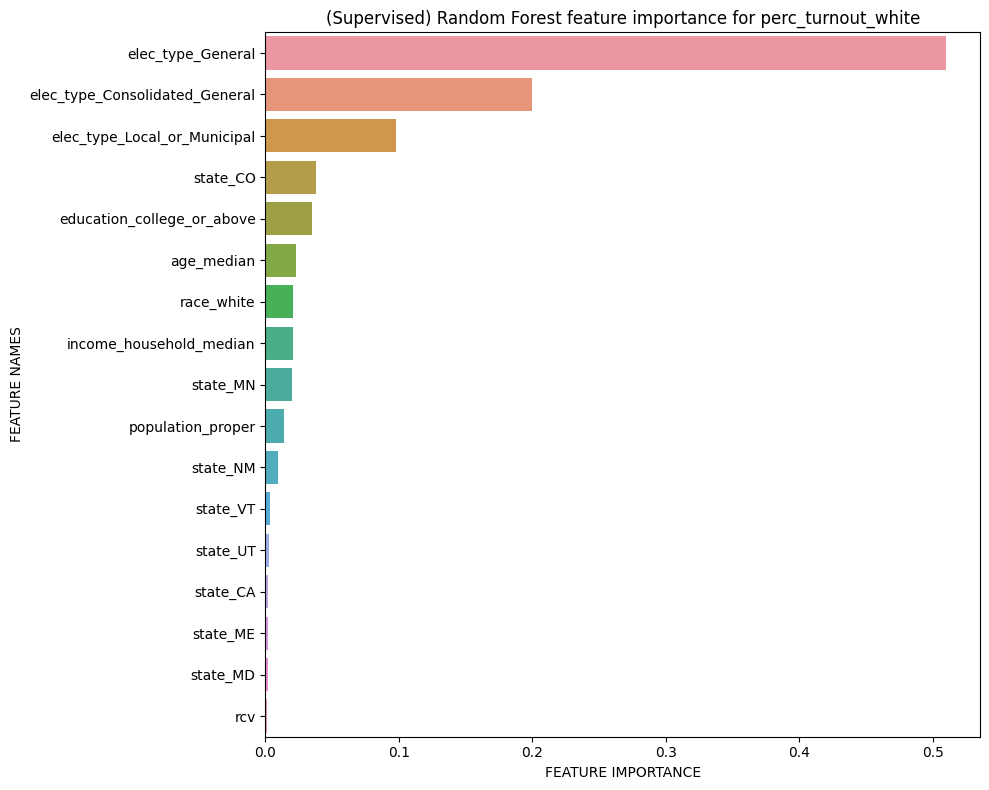

In [44]:
best_params_white_turnout = train(df_white_turnout, 'perc_turnout_white')
print(best_params_white_turnout)

### 2.1 Linear Regressionression

In [45]:
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     213.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.11e-139
Time:                        15:05:39   Log-Likelihood:                -901.25
No. Observations:                 284   AIC:                             1835.
Df Residuals:                     268   BIC:                             1893.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,4.557187,6.116775
1,Mean_Squared_Error,33.414443,60.319082
2,R_squared_score,0.922606,0.859334


In [46]:
df_white_turnout.drop(columns = 'state_MD', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     206.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.41e-137
Time:                        15:05:39   Log-Likelihood:                -910.55
No. Observations:                 284   AIC:                             1853.
Df Residuals:                     268   BIC:                             1911.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,4.716927,5.542291
1,Mean_Squared_Error,35.674960,48.378108
2,R_squared_score,0.920362,0.863191


In [47]:
df_white_turnout.drop(columns = 'state_NM', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 15)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     202.2
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          9.18e-134
Time:                        15:05:39   Log-Likelihood:                -921.46
No. Observations:                 284   AIC:                             1873.
Df Residuals:                     269   BIC:                             1928.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,4.970079,4.837867
1,Mean_Squared_Error,38.524842,38.890159
2,R_squared_score,0.913222,0.897788


In [48]:
df_white_turnout.drop(columns = 'age_median', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 14)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     189.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.17e-127
Time:                        15:05:39   Log-Likelihood:                -930.06
No. Observations:                 284   AIC:                             1888.
Df Residuals:                     270   BIC:                             1939.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,4.918214,5.936791
1,Mean_Squared_Error,40.928885,52.866304
2,R_squared_score,0.901240,0.888171


In [49]:
df_white_turnout.drop(columns = 'population_proper', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 13)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     196.6
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          4.60e-126
Time:                        15:05:39   Log-Likelihood:                -942.70
No. Observations:                 284   AIC:                             1911.
Df Residuals:                     271   BIC:                             1959.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.250052,4.841268
1,Mean_Squared_Error,44.739997,35.589308
2,R_squared_score,0.896948,0.913059


In [50]:
df_white_turnout.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 12)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     223.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.84e-129
Time:                        15:05:39   Log-Likelihood:                -940.88
No. Observations:                 284   AIC:                             1906.
Df Residuals:                     272   BIC:                             1950.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.242981,4.666651
1,Mean_Squared_Error,44.169181,39.487265
2,R_squared_score,0.900446,0.896504


In [51]:
df_white_turnout.drop(columns = 'income_household_median', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 11)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     255.6
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.57e-132
Time:                        15:05:39   Log-Likelihood:                -935.92
No. Observations:                 284   AIC:                             1894.
Df Residuals:                     273   BIC:                             1934.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.031111,5.580468
1,Mean_Squared_Error,42.652261,46.470630
2,R_squared_score,0.903492,0.878877


In [52]:
df_white_turnout.drop(columns = 'state_VT', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 10)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     261.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          4.96e-129
Time:                        15:05:39   Log-Likelihood:                -943.47
No. Observations:                 284   AIC:                             1907.
Df Residuals:                     274   BIC:                             1943.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.263021,4.659997
1,Mean_Squared_Error,44.981500,37.234157
2,R_squared_score,0.895842,0.913175


In [53]:
df_white_turnout.drop(columns = 'state_ME', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 9)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     301.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.71e-131
Time:                        15:05:39   Log-Likelihood:                -941.91
No. Observations:                 284   AIC:                             1902.
Df Residuals:                     275   BIC:                             1935.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.240534,4.986650
1,Mean_Squared_Error,44.492197,40.734185
2,R_squared_score,0.897599,0.901473


In [54]:
df_white_turnout.drop(columns = 'state_UT', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 8)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     365.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.62e-135
Time:                        15:05:39   Log-Likelihood:                -932.82
No. Observations:                 284   AIC:                             1882.
Df Residuals:                     276   BIC:                             1911.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.043174,5.730248
1,Mean_Squared_Error,41.732666,53.483668
2,R_squared_score,0.902508,0.877442


## 3. Predict Average Age

In [55]:
df_mean_age = get_cols_model(voter_df, cities, 'mean_age')                      
df_mean_age.head()

,rcv,Residence_Addresses_City,mean_age,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,54.184656,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,57.574886,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,61.541445,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,56.419342,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,51.515875,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


### 3.1 Random Forest 

mean_age
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best params after cv: {'max_depth': None, 'max_features': 4, 'n_estimators': 50} 

Train
Mean Absolute Error: 0.591
Mean Squared Error: 0.657
R-squared scores: 0.958

Test
Mean Absolute Error: 1.755
Mean Squared Error: 6.277
R-squared scores: 0.631
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.590866  1.754973
1   Mean_Squared_Error  0.657417  6.277345
2      R_squared_score  0.957666  0.631074


Feature 0 (elec_type_General) importance: 0.24238057174048436
Feature 1 (age_median) importance: 0.1920624567542516
Feature 2 (elec_type_Consolidated_General) importance: 0.10352256635361368
Feature 3 (population_proper) importance: 0.09192652081798727
Feature 4 (income_household_median) importance: 0.07650392906397706
Feature 5 (elec_type_Local_or_Municipal) importance: 0.07411170332606064
Feature 6 (race_white) importance: 0.0705811775517617
Feature 7 (e

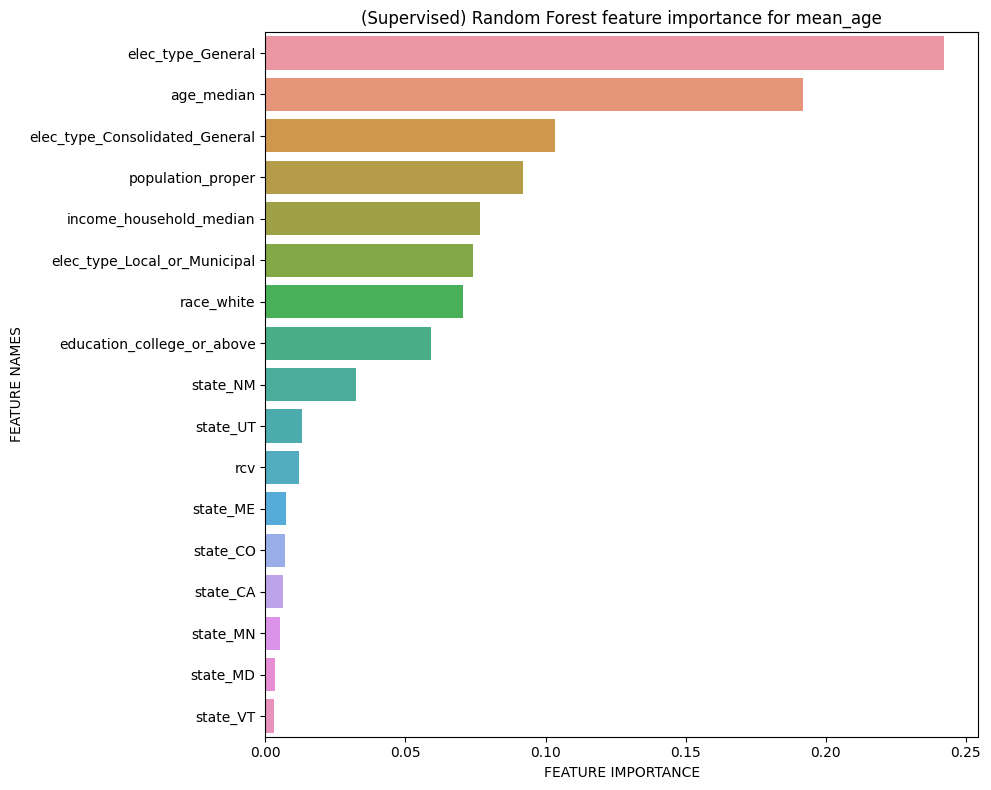

In [56]:
best_params_mean_age = train(df_mean_age, 'mean_age')
print(best_params_mean_age)

### 3.1 Linear Regression

In [57]:
train_lrg_sm(df_mean_age, 'mean_age') 

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     64.36
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           1.29e-79
Time:                        15:05:41   Log-Likelihood:                -575.26
No. Observations:                 284   AIC:                             1183.
Df Residuals:                     268   BIC:                             1241.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,1.452072,1.547358
1,Mean_Squared_Error,3.364358,3.891792
2,R_squared_score,0.782711,0.772248


In [58]:
df_mean_age.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_mean_age, 'mean_age') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     72.18
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           1.88e-82
Time:                        15:05:41   Log-Likelihood:                -582.93
No. Observations:                 284   AIC:                             1196.
Df Residuals:                     269   BIC:                             1251.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,1.459181,1.559088
1,Mean_Squared_Error,3.551169,3.439987
2,R_squared_score,0.789772,0.700721


## 4. Predict Income < 50K

In [59]:
df_income_under_50k = get_cols_model(voter_df, cities, 'perc_turnout_under_50k')                      
df_income_under_50k.head()

,rcv,Residence_Addresses_City,perc_turnout_under_50k,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.474739,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.489294,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.110822,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.306489,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.539032,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


### 4.1 Random Forest

perc_turnout_under_50k
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best params after cv: {'max_depth': None, 'max_features': 8, 'n_estimators': 100} 

Train
Mean Absolute Error: 0.02
Mean Squared Error: 0.001
R-squared scores: 0.985

Test
Mean Absolute Error: 0.054
Mean Squared Error: 0.005
R-squared scores: 0.895
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.019588  0.053784
1   Mean_Squared_Error  0.000631  0.004842
2      R_squared_score  0.985373  0.894606


Feature 0 (elec_type_General) importance: 0.431258734199017
Feature 1 (elec_type_Consolidated_General) importance: 0.15482363948544434
Feature 2 (elec_type_Local_or_Municipal) importance: 0.11674637242275852
Feature 3 (race_white) importance: 0.06709170311178078
Feature 4 (income_household_median) importance: 0.06545273168018934
Feature 5 (education_college_or_above) importance: 0.047159638021210204
Feature 6 (age_median) importance: 0.034193

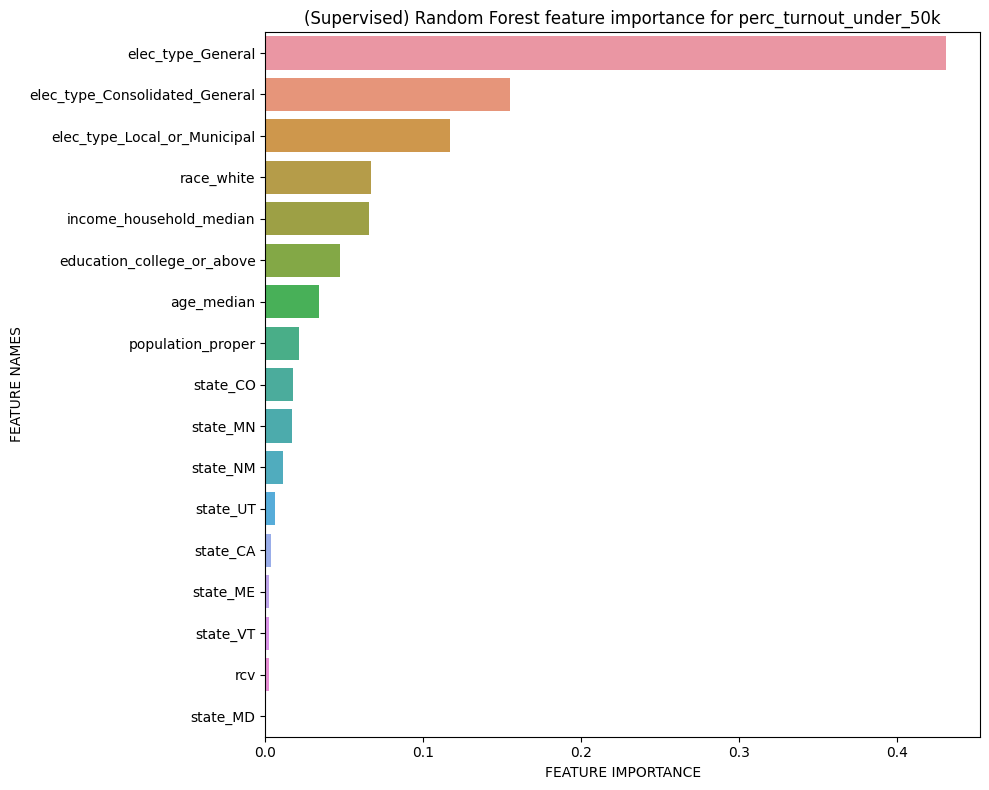

In [60]:
best_params_income_under_50k = train(df_income_under_50k, 'perc_turnout_under_50k')
print(best_params_income_under_50k)

### 4.1 Linear Regression

In [61]:
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     112.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.52e-106
Time:                        15:05:43   Log-Likelihood:                 328.07
No. Observations:                 284   AIC:                            -624.1
Df Residuals:                     268   BIC:                            -565.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.059379,0.054948
1,Mean_Squared_Error,0.005810,0.004666
2,R_squared_score,0.862983,0.904682


In [62]:
df_income_under_50k.drop(columns = 'state_VT', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     119.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          5.78e-109
Time:                        15:05:43   Log-Likelihood:                 332.42
No. Observations:                 284   AIC:                            -632.8
Df Residuals:                     268   BIC:                            -574.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.058870,0.058730
1,Mean_Squared_Error,0.005634,0.005377
2,R_squared_score,0.869431,0.880994


In [63]:
df_income_under_50k.drop(columns = 'state_MD', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 15)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     136.1
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.65e-113
Time:                        15:05:44   Log-Likelihood:                 333.80
No. Observations:                 284   AIC:                            -637.6
Df Residuals:                     269   BIC:                            -582.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.059226,0.062528
1,Mean_Squared_Error,0.005580,0.005869
2,R_squared_score,0.876303,0.842618


In [64]:
df_income_under_50k.drop(columns = 'state_CA', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 14)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     143.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          6.82e-113
Time:                        15:05:44   Log-Likelihood:                 335.88
No. Observations:                 284   AIC:                            -643.8
Df Residuals:                     270   BIC:                            -592.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.057502,0.063634
1,Mean_Squared_Error,0.005499,0.005967
2,R_squared_score,0.873375,0.866721


In [65]:
df_income_under_50k.drop(columns = 'state_ME', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 13)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     156.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.61e-114
Time:                        15:05:44   Log-Likelihood:                 332.87
No. Observations:                 284   AIC:                            -639.7
Df Residuals:                     271   BIC:                            -592.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.058458,0.060280
1,Mean_Squared_Error,0.005617,0.005605
2,R_squared_score,0.873742,0.861378


In [66]:
df_income_under_50k.drop(columns = 'race_white', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 12)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     177.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.41e-117
Time:                        15:05:44   Log-Likelihood:                 338.10
No. Observations:                 284   AIC:                            -652.2
Df Residuals:                     272   BIC:                            -608.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.058297,0.071155
1,Mean_Squared_Error,0.005413,0.008166
2,R_squared_score,0.877753,0.802684


In [67]:
df_income_under_50k.drop(columns = 'education_college_or_above', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 11)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     189.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.09e-116
Time:                        15:05:44   Log-Likelihood:                 337.28
No. Observations:                 284   AIC:                            -652.6
Df Residuals:                     273   BIC:                            -612.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.059703,0.076129
1,Mean_Squared_Error,0.005445,0.008819
2,R_squared_score,0.874263,0.805418


In [68]:
df_income_under_50k.drop(columns = 'income_household_median', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 10)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     159.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.38e-103
Time:                        15:05:44   Log-Likelihood:                 300.13
No. Observations:                 284   AIC:                            -580.3
Df Residuals:                     274   BIC:                            -543.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.067083,0.069041
1,Mean_Squared_Error,0.007073,0.007213
2,R_squared_score,0.839997,0.825019


In [69]:
df_income_under_50k.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 9)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     186.1
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.79e-106
Time:                        15:05:44   Log-Likelihood:                 305.56
No. Observations:                 284   AIC:                            -593.1
Df Residuals:                     275   BIC:                            -560.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.066274,0.070092
1,Mean_Squared_Error,0.006808,0.008131
2,R_squared_score,0.844118,0.812784


In [70]:
df_income_under_50k.drop(columns = 'population_proper', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 8)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     202.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          8.69e-105
Time:                        15:05:44   Log-Likelihood:                 300.28
No. Observations:                 284   AIC:                            -584.6
Df Residuals:                     276   BIC:                            -555.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.066972,0.071725
1,Mean_Squared_Error,0.007066,0.007366
2,R_squared_score,0.836981,0.837644


## 5. Predict Income > 100K

In [71]:
df_income_over_100k = get_cols_model(voter_df, cities, 'perc_turnout_over_100k')      
df_income_over_100k.head()

,rcv,Residence_Addresses_City,perc_turnout_over_100k,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.501815,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.554673,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.138876,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.432444,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.687079,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


### 5.1 Random Forest

perc_turnout_over_100k
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best params after cv: {'max_depth': None, 'max_features': 8, 'n_estimators': 100} 

Train
Mean Absolute Error: 0.015
Mean Squared Error: 0.0
R-squared scores: 0.991

Test
Mean Absolute Error: 0.043
Mean Squared Error: 0.003
R-squared scores: 0.935
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.015050  0.042828
1   Mean_Squared_Error  0.000371  0.002940
2      R_squared_score  0.991187  0.934857


Feature 0 (elec_type_General) importance: 0.5375500746326263
Feature 1 (elec_type_Consolidated_General) importance: 0.18933518094840598
Feature 2 (elec_type_Local_or_Municipal) importance: 0.09412684704223886
Feature 3 (state_CO) importance: 0.0348756145390428
Feature 4 (education_college_or_above) importance: 0.03298581857536067
Feature 5 (race_white) importance: 0.02832902609566346
Feature 6 (age_median) importance: 0.018590034526327605
Feat

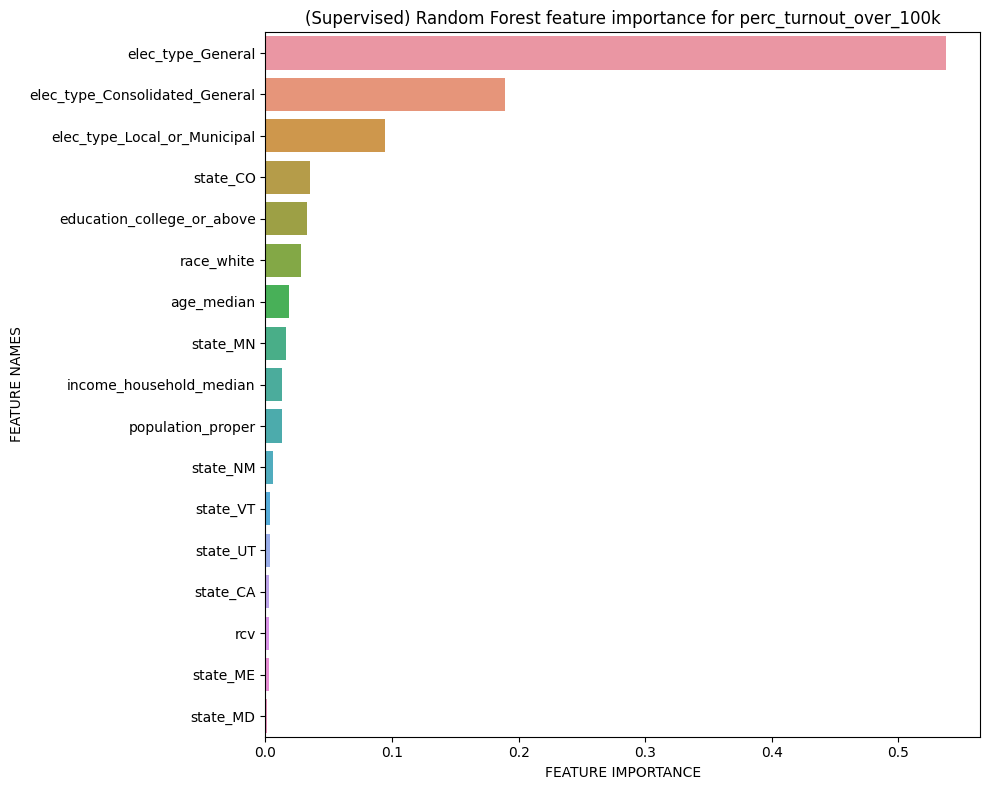

In [72]:
best_params_income_over_100k = train(df_income_over_100k, 'perc_turnout_over_100k')
print(best_params_income_over_100k)

### 5.1 Linear Regression

In [73]:
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     191.2
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.69e-133
Time:                        15:05:46   Log-Likelihood:                 394.90
No. Observations:                 284   AIC:                            -757.8
Df Residuals:                     268   BIC:                            -699.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.048464,0.045010
1,Mean_Squared_Error,0.003629,0.002905
2,R_squared_score,0.914553,0.930351


In [74]:
df_income_over_100k.drop(columns = 'state_CA', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     211.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          6.05e-139
Time:                        15:05:46   Log-Likelihood:                 401.32
No. Observations:                 284   AIC:                            -770.6
Df Residuals:                     268   BIC:                            -712.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.048344,0.047237
1,Mean_Squared_Error,0.003468,0.003531
2,R_squared_score,0.922219,0.899343


In [75]:
df_income_over_100k.drop(columns = 'state_MD', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 15)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     216.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.27e-137
Time:                        15:05:46   Log-Likelihood:                 403.05
No. Observations:                 284   AIC:                            -776.1
Df Residuals:                     269   BIC:                            -721.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.046246,0.051684
1,Mean_Squared_Error,0.003426,0.003668
2,R_squared_score,0.918440,0.916544


In [76]:
df_income_over_100k.drop(columns = 'state_ME', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 14)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     235.1
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          7.63e-139
Time:                        15:05:46   Log-Likelihood:                 399.41
No. Observations:                 284   AIC:                            -770.8
Df Residuals:                     270   BIC:                            -719.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.048859,0.047054
1,Mean_Squared_Error,0.003515,0.003652
2,R_squared_score,0.918830,0.908564


In [77]:
df_income_over_100k.drop(columns = 'race_white', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 13)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     249.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.20e-138
Time:                        15:05:46   Log-Likelihood:                 398.53
No. Observations:                 284   AIC:                            -771.1
Df Residuals:                     271   BIC:                            -723.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.048031,0.054136
1,Mean_Squared_Error,0.003537,0.004245
2,R_squared_score,0.916855,0.901707


In [78]:
df_income_over_100k.drop(columns = 'education_college_or_above', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 12)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     215.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.54e-127
Time:                        15:05:46   Log-Likelihood:                 372.89
No. Observations:                 284   AIC:                            -721.8
Df Residuals:                     272   BIC:                            -678.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.051924,0.055857
1,Mean_Squared_Error,0.004237,0.005321
2,R_squared_score,0.896838,0.891781


In [79]:
df_income_over_100k.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 11)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     258.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          5.26e-133
Time:                        15:05:46   Log-Likelihood:                 376.65
No. Observations:                 284   AIC:                            -731.3
Df Residuals:                     273   BIC:                            -691.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.051126,0.065650
1,Mean_Squared_Error,0.004127,0.006244
2,R_squared_score,0.904610,0.841359


In [80]:
df_income_over_100k.drop(columns = 'population_proper', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 10)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     259.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.37e-128
Time:                        15:05:46   Log-Likelihood:                 364.67
No. Observations:                 284   AIC:                            -709.3
Df Residuals:                     274   BIC:                            -672.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.053418,0.056787
1,Mean_Squared_Error,0.004490,0.004637
2,R_squared_score,0.895067,0.889562


In [81]:
df_income_over_100k.drop(columns = 'state_NM', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 9)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     297.2
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.44e-130
Time:                        15:05:46   Log-Likelihood:                 363.06
No. Observations:                 284   AIC:                            -708.1
Df Residuals:                     275   BIC:                            -675.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.053061,0.056677
1,Mean_Squared_Error,0.004541,0.004731
2,R_squared_score,0.896343,0.873681


In [82]:
df_income_over_100k.drop(columns = 'income_household_median', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 8)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     330.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.77e-130
Time:                        15:05:46   Log-Likelihood:                 360.97
No. Observations:                 284   AIC:                            -705.9
Df Residuals:                     276   BIC:                            -676.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.054243,0.053876
1,Mean_Squared_Error,0.004608,0.004723
2,R_squared_score,0.893355,0.883105
